In [1]:
import json
import pprint
from pathlib import Path
import sys
sys.path.insert(1, '../src/utils')
import ipdb
import itertools
from collections import Counter


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gensim.utils import simple_preprocess
from gensim import corpora, models
from gensim.models import Word2Vec
from gensim.models import CoherenceModel
from sklearn.manifold import TSNE, SpectralEmbedding
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
from scipy.spatial.distance import cdist

from data import preprocessing

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Variables


In [3]:
num_topics = 15
use_title = True
# don't use stemming
stemming = False
lemmatization = True
# use nltk since it is a lot faster than spacy and the results are better with nltk
lib = "nltk"

input_path = Path("../src/data/data_jmlr_vol13-21.json")

# Data loading and preparation

## load

In [4]:
def load_data():
    with open(input_path, encoding="utf-8") as f:
        data = json.load(f)
    data_df = pd.json_normalize(data['papers'])
    corpus = data_df["abstract"]
    if use_title:
        corpus = data_df["title"] + " " + corpus 
    return corpus
corpus = load_data()

## preprocess
TODO: save after preprocessing so that there is no need to wait for a long time

In [5]:
corpus = preprocessing(
    corpus,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15
)

Dropping 0 entries of corpus, due to nan ...


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
54it [00:00, 268.00it/s]

Starting tokenization ...


1261it [00:04, 259.76it/s]


### tfidf

The TfidfVectorizer does additionally also tokenization and stop word removal.

In [6]:
vectorizer_sklearn = TfidfVectorizer(stop_words='english')
tfidf_corpus_sklearn_preprocessed = vectorizer_sklearn.fit_transform(corpus["abstract"])

Since we implemented our own preprocessing this is not necessary. Therefore we don't use tokenization and lowercase. Since we didn't implement stop word removal yet(TODO: false -> remove stopword removal by sklearn) we use the stopword removal by sklearn.

In [7]:
def identity_tokenizer(text):
    return text

def get_tfidf_corpus(corpus):
    vectorizer = TfidfVectorizer(tokenizer=identity_tokenizer, lowercase=False)  
    return vectorizer, vectorizer.fit_transform(corpus["token"])

vectorizer, tfidf_corpus = get_tfidf_corpus(corpus)

## get optimal k

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


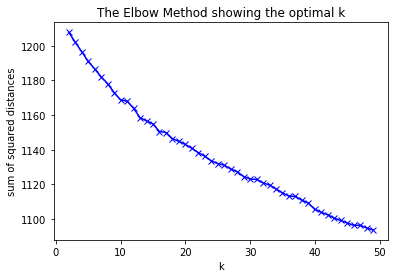

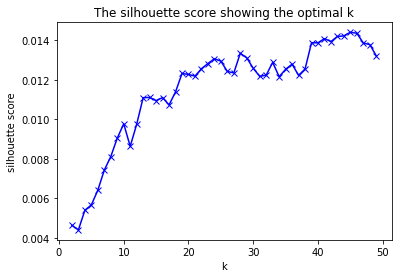

In [7]:
def find_k(corpus, num_topics):
    sum_of_suared_distances = []
    silhouette_scores = []
    K = range(2,num_topics)
    for k in K:
        model = KMeans(n_clusters=k, random_state=10)
        model.fit(corpus)
        sum_of_suared_distances.append(model.inertia_)
        labels = model.labels_
        silhouette_scores.append(metrics.silhouette_score(tfidf_corpus, labels, metric='euclidean'))

    # Plot the elbow
    plt.plot(K, sum_of_suared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('sum of squared distances')
    plt.title('The Elbow Method showing the optimal k')
    plt.show()

    # Plot silhouette scores
    plt.plot(K, silhouette_scores, 'bx-')
    plt.xlabel('k')
    plt.ylabel('silhouette score')
    plt.title('The silhouette score showing the optimal k')
    plt.show()
find_k(tfidf_corpus, 50)

 There is no elbow visible. There could be several reasons for this: https://stats.stackexchange.com/questions/89679/what-do-you-do-when-theres-no-elbow-point-for-kmeans-clustering

Silhouette score explained:
https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
TODO: proper visualization of silhouette score

Elbow Method explained: https://www.datanovia.com/en/lessons/determining-the-optimal-number-of-clusters-3-must-know-methods/

# Clustering

In [8]:
def fit_model(model, corpus):
    model.fit(corpus)

def print_and_get_clusters(model, vectorizer, n_components=None, svd=None):
    print("Top terms per cluster:")
    if n_components:
        original_space_centroids = svd.inverse_transform(model.cluster_centers_)
        order_centroids = original_space_centroids.argsort()[:, ::-1]
    else:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    terms = vectorizer.get_feature_names()
    clusters = []
    for i in range(num_topics):
        print("Cluster %d:" % i),
        cluster = []
        for ind in order_centroids[i, :10]:
            print(' %s' % terms[ind])
            cluster.append(terms[ind])
        clusters.append(cluster)
        print("\n")
    return clusters
    
model = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model, tfidf_corpus)
clusters = print_and_get_clusters(model, vectorizer)


Top terms per cluster:
Cluster 0:
 dimensional
 graphical
 model
 high
 lasso
 test
 data
 selection
 regression
 algorithm


Cluster 1:
 data
 set
 statistical
 approach
 function
 model
 problem
 classification
 uncertainty
 loss


Cluster 2:
 gradient
 stochastic
 convex
 optimization
 algorithm
 convergence
 descent
 function
 method
 non


Cluster 3:
 model
 inference
 gaussian
 latent
 causal
 variational
 process
 data
 variable
 bayesian


Cluster 4:
 learning
 regularization
 distributed
 algorithm
 problem
 optimization
 framework
 machine
 data
 method


Cluster 5:
 label
 learning
 active
 bound
 complexity
 sample
 distribution
 algorithm
 class
 problem


Cluster 6:
 graph
 vertex
 cluster
 problem
 model
 data
 random
 community
 clustering
 node


Cluster 7:
 matrix
 rank
 tensor
 low
 completion
 factorization
 bound
 decomposition
 norm
 data


Cluster 8:
 regression
 risk
 algorithm
 method
 linear
 loss
 problem
 data
 optimization
 estimator


Cluster 9:
 feature
 

Since the words which define the clusters look weird I use the sklearn preprocessing in the following. Our preprocessing should be improved. Or we decide to just use the sklearn preprocessing. But as far as I know they don't use lemmatization and stemming (TODO: true?)
With no stemming, the use of nltk and lowering the words, the result seems to be better. Therfore we use our own preprocessing again.

In [9]:
model_skelarn_preprocessed = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_skelarn_preprocessed, tfidf_corpus_sklearn_preprocessed)
print_and_get_clusters(model_skelarn_preprocessed, vectorizer_sklearn)


Top terms per cluster:
Cluster 0:
 topic
 models
 learning
 bayesian
 model
 margin
 time
 network
 passive
 alexey


Cluster 1:
 distributed
 policy
 communication
 algorithm
 learning
 algorithms
 convergence
 method
 function
 gradient


Cluster 2:
 variance
 monte
 carlo
 asymptotic
 derivative
 step
 mcmc
 bias
 gradient
 langevin


Cluster 3:
 lasso
 sparsity
 group
 sparse
 regression
 dimensional
 high
 selection
 regularization
 method


Cluster 4:
 multi
 learning
 loss
 classification
 task
 class
 problem
 svm
 regression
 vector


Cluster 5:
 svm
 risk
 validation
 cross
 regression
 model
 support
 selection
 vector
 machine


Cluster 6:
 kernel
 online
 regret
 learning
 kernels
 algorithms
 algorithm
 regression
 function
 density


Cluster 7:
 matrix
 rank
 completion
 low
 matrices
 norm
 sampling
 factorization
 tensor
 approximation


Cluster 8:
 learning
 data
 algorithms
 machine
 classification
 python
 analysis
 time
 supervised
 framework


Cluster 9:
 stochast

[['topic',
  'models',
  'learning',
  'bayesian',
  'model',
  'margin',
  'time',
  'network',
  'passive',
  'alexey'],
 ['distributed',
  'policy',
  'communication',
  'algorithm',
  'learning',
  'algorithms',
  'convergence',
  'method',
  'function',
  'gradient'],
 ['variance',
  'monte',
  'carlo',
  'asymptotic',
  'derivative',
  'step',
  'mcmc',
  'bias',
  'gradient',
  'langevin'],
 ['lasso',
  'sparsity',
  'group',
  'sparse',
  'regression',
  'dimensional',
  'high',
  'selection',
  'regularization',
  'method'],
 ['multi',
  'learning',
  'loss',
  'classification',
  'task',
  'class',
  'problem',
  'svm',
  'regression',
  'vector'],
 ['svm',
  'risk',
  'validation',
  'cross',
  'regression',
  'model',
  'support',
  'selection',
  'vector',
  'machine'],
 ['kernel',
  'online',
  'regret',
  'learning',
  'kernels',
  'algorithms',
  'algorithm',
  'regression',
  'function',
  'density'],
 ['matrix',
  'rank',
  'completion',
  'low',
  'matrices',
  'norm

lemmatization would be good, because the defining words are redundant(e.g. models and model, graphs and graph, ...)

# Visualization

TODO: merge somehow with visualization of gensim_inspections? would be very difficult because of different inputs


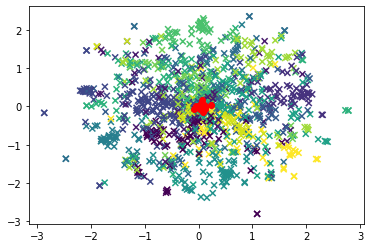

In [10]:
def plot(model, corpus, n_components=None):
    random_state = 1
    centroids = model.cluster_centers_

    tsne_init = 'pca'  # could also be 'random'
    tsne_perplexity = 20.0
    tsne_early_exaggeration = 4.0
    tsne_learning_rate = 10
    tsne = TSNE(n_components=2, random_state=random_state, init=tsne_init,
        perplexity=tsne_perplexity,
        early_exaggeration=tsne_early_exaggeration, learning_rate=tsne_learning_rate)
    if n_components:
        transformed = tsne.fit_transform(np.concatenate((corpus, centroids)))
    else:
        transformed = tsne.fit_transform(np.concatenate((corpus.todense(), centroids)))
    plt.scatter(transformed[:-num_topics, 0], transformed[:-num_topics, 1], c=model.labels_, marker='x')
    plt.scatter(transformed[-num_topics:, 0], transformed[-num_topics:, 1], c="red", marker='o')

    plt.show()
plot(model, tfidf_corpus)

# LSA and kmeans

In [11]:
def get_lsa_transformation(n_components, corpus):
    svd = TruncatedSVD(n_components)
    normalizer = Normalizer(copy=False)
    lsa = make_pipeline(svd, normalizer)
    return lsa.fit_transform(corpus),svd

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


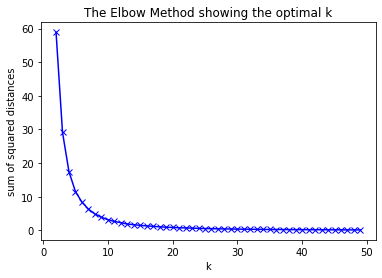

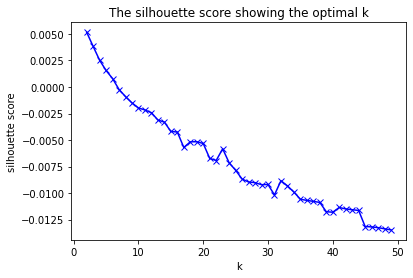

n_components:  3


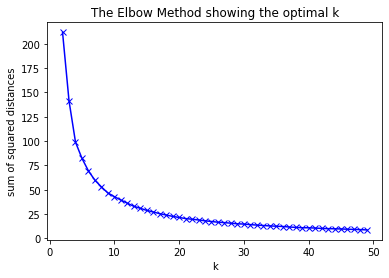

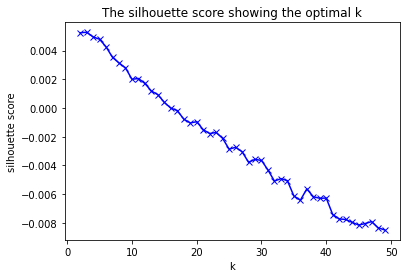

n_components:  4


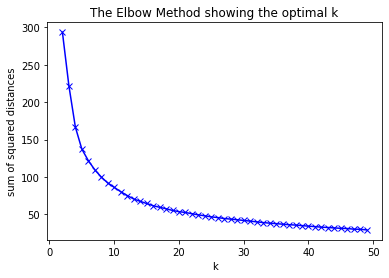

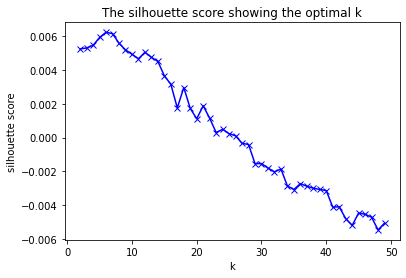

n_components:  5


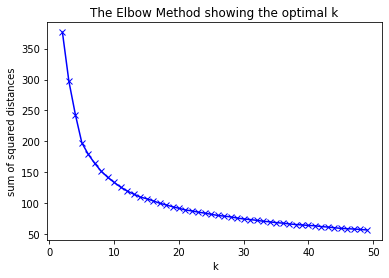

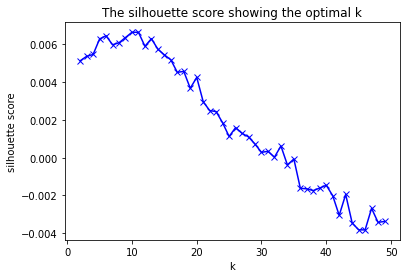

n_components:  6


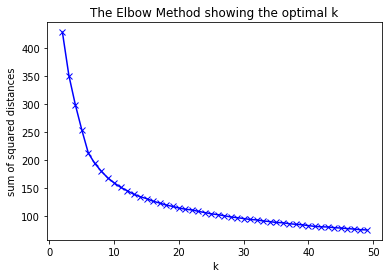

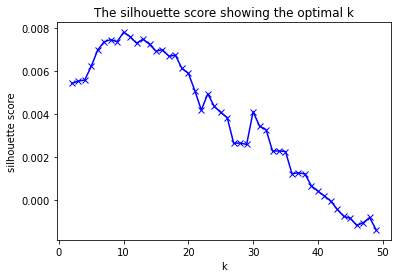

n_components:  7


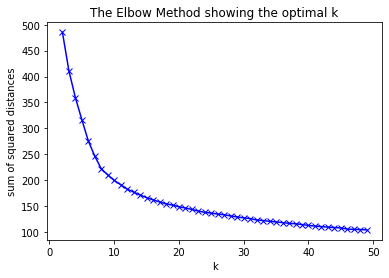

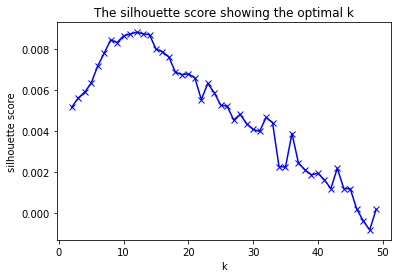

n_components:  8


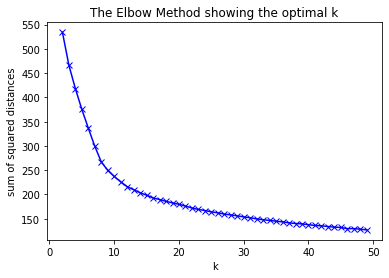

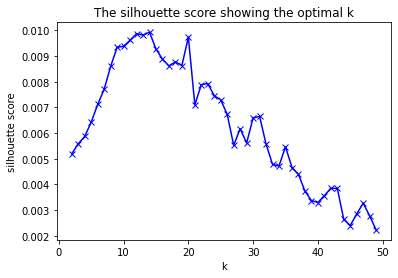

n_components:  9


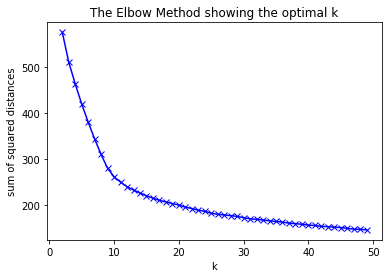

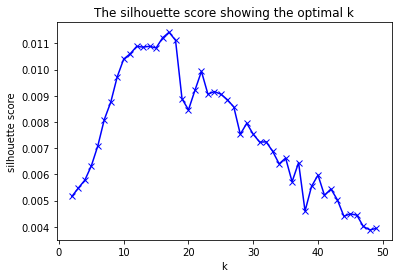

n_components:  10


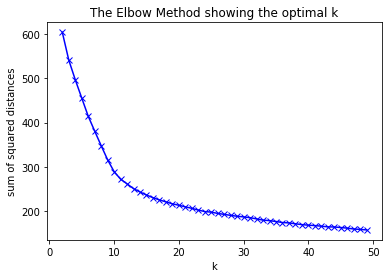

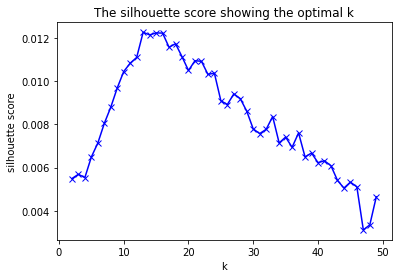

In [12]:
def find_n_components_and_k(corpus):
    for n_components in [2,3,4,5,6,7,8,9,10]:
        print("n_components: ", n_components)
        X, svd = get_lsa_transformation(n_components, corpus)
        find_k(X, 50)
        
find_n_components_and_k(tfidf_corpus)

With LSA and kmeans a elbow is visible! The peak of the silhouette score moves to the right the higher n_component.
The optimal cluster number seems to be 15? With n_components = 10 also the peak of the silhouette score is at k=15. So maybe use num_topics= 15 and n_components=9?

In [12]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus)
num_topics = 15
model_lsa = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_lsa, X)
clusters_with_lsa = print_and_get_clusters(model_lsa, vectorizer, n_components=n_components, svd=svd)


Top terms per cluster:
Cluster 0:
 policy
 learning
 algorithm
 bound
 distribution
 process
 reinforcement
 action
 regret
 bayesian


Cluster 1:
 regression
 model
 estimator
 data
 method
 estimation
 rate
 high
 dimensional
 selection


Cluster 2:
 learning
 algorithm
 method
 data
 problem
 optimization
 convex
 machine
 function
 gradient


Cluster 3:
 graph
 causal
 model
 graphical
 variable
 algorithm
 data
 effect
 problem
 learning


Cluster 4:
 bound
 learning
 loss
 sample
 rate
 class
 algorithm
 policy
 label
 distribution


Cluster 5:
 network
 model
 neural
 node
 graph
 learning
 deep
 community
 structure
 layer


Cluster 6:
 kernel
 learning
 regression
 function
 estimator
 rate
 space
 mean
 approximation
 data


Cluster 7:
 optimization
 algorithm
 gradient
 stochastic
 convex
 method
 problem
 function
 convergence
 descent


Cluster 8:
 algorithm
 problem
 function
 convex
 method
 optimization
 learning
 bound
 gradient
 stochastic


Cluster 9:
 learning
 data

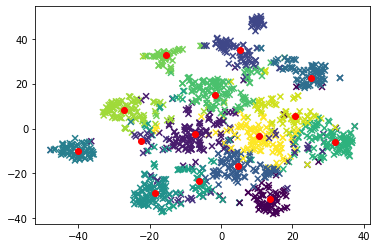

In [15]:
plot(model_lsa, X, n_components=n_components)

cluster centers look better than without lsa.

# Remove words which appear often in all clusters

In [16]:
terms = list(itertools.chain.from_iterable(clusters))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'data': 10, 'algorithm': 9, 'model': 6, 'learning': 6, 'problem': 5, 'function': 4, 'regression': 3, 'loss': 3, 'optimization': 3, 'method': 3, 'bound': 3, 'bayesian': 2, 'distribution': 2, 'random': 2, 'norm': 2, 'estimator': 2, 'classifier': 2, 'network': 2, 'training': 2, 'decision': 2, 'dimensional': 1, 'graphical': 1, 'high': 1, 'lasso': 1, 'test': 1, 'selection': 1, 'set': 1, 'statistical': 1, 'approach': 1, 'classification': 1, 'uncertainty': 1, 'gradient': 1, 'stochastic': 1, 'convex': 1, 'convergence': 1, 'descent': 1, 'non': 1, 'inference': 1, 'gaussian': 1, 'latent': 1, 'causal': 1, 'variational': 1, 'process': 1, 'variable': 1, 'regularization': 1, 'distributed': 1, 'framework': 1, 'machine': 1, 'label': 1, 'active': 1, 'complexity': 1, 'sample': 1, 'class': 1, 'graph': 1, 'vertex': 1, 'cluster': 1, 'community': 1, 'clustering': 1, 'node': 1, 'matrix': 1, 'rank': 1, 'tensor': 1, 'low': 1, 'completion': 1, 'factorization': 1, 'de

In [17]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'learning': 10, 'data': 10, 'algorithm': 9, 'method': 8, 'model': 7, 'bound': 4, 'problem': 4, 'function': 4, 'rate': 3, 'optimization': 3, 'convex': 3, 'gradient': 3, 'graph': 3, 'label': 3, 'feature': 3, 'policy': 2, 'distribution': 2, 'process': 2, 'bayesian': 2, 'regression': 2, 'estimator': 2, 'machine': 2, 'variable': 2, 'class': 2, 'network': 2, 'stochastic': 2, 'classification': 2, 'task': 2, 'inference': 2, 'set': 2, 'reinforcement': 1, 'action': 1, 'regret': 1, 'estimation': 1, 'high': 1, 'dimensional': 1, 'selection': 1, 'causal': 1, 'graphical': 1, 'effect': 1, 'loss': 1, 'sample': 1, 'neural': 1, 'node': 1, 'deep': 1, 'community': 1, 'structure': 1, 'layer': 1, 'kernel': 1, 'space': 1, 'mean': 1, 'approximation': 1, 'convergence': 1, 'descent': 1, 'library': 1, 'multi': 1, 'gaussian': 1, 'latent': 1, 'variational': 1, 'clustering': 1, 'cluster': 1, 'density': 1, 'spectral': 1, 'based': 1, 'point': 1, 'matrix': 1, 'rank': 1, 'lo

Words that should be removed are algorithm, data, learning, method, model. This insight corresponds to the insight we get by printing the topwords of BoW and tfidf corpuses (milestone) 

In [18]:
custom_stopwords = ["algorithm", "data", "learning", "method", "model"]

In [19]:
corpus_new = load_data()

corpus_stopwords = preprocessing(
    corpus_new,
    lib=lib,
    stemming=stemming,
    lemmatization=lemmatization,
    min_word_len=2,
    max_word_len=15,
    custom_stopwords = custom_stopwords
)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jessi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
31it [00:00, 306.67it/s]

Dropping 0 entries of corpus, due to nan ...
Starting tokenization ...


1261it [00:04, 267.48it/s]


In [20]:
vectorizer_stopwords, tfidf_corpus_stopwords = get_tfidf_corpus(corpus_stopwords)

In [21]:
n_components = 10
X, svd = get_lsa_transformation(n_components, tfidf_corpus_stopwords)
num_topics = 15
model_stopwords = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
fit_model(model_stopwords, X)
clusters_with_lsa_stopwords = print_and_get_clusters(model_stopwords, vectorizer_stopwords, n_components=n_components, svd=svd)

Top terms per cluster:
Cluster 0:
 feature
 machine
 library
 classification
 python
 multi
 task
 source
 set
 label


Cluster 1:
 feature
 classification
 label
 set
 class
 problem
 multi
 machine
 task
 classifier


Cluster 2:
 regression
 estimator
 variable
 dimensional
 high
 estimation
 sparse
 lasso
 rate
 selection


Cluster 3:
 clustering
 graph
 cluster
 density
 spectral
 based
 approximation
 label
 bound
 matrix


Cluster 4:
 bound
 loss
 rate
 convex
 function
 problem
 optimal
 regression
 convergence
 class


Cluster 5:
 policy
 problem
 bound
 action
 reinforcement
 function
 decision
 space
 process
 gradient


Cluster 6:
 network
 neural
 node
 community
 deep
 structure
 layer
 graph
 graphical
 training


Cluster 7:
 bound
 distribution
 class
 sample
 loss
 estimator
 label
 rate
 optimal
 regret


Cluster 8:
 kernel
 regression
 function
 estimator
 space
 rate
 density
 mean
 hilbert
 least


Cluster 9:
 graph
 graphical
 clustering
 network
 causal
 cluster
 

In [22]:
terms = list(itertools.chain.from_iterable(clusters_with_lsa_stopwords))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'problem': 7, 'rate': 5, 'bound': 5, 'function': 5, 'label': 4, 'graph': 4, 'machine': 3, 'class': 3, 'regression': 3, 'estimator': 3, 'variable': 3, 'convex': 3, 'convergence': 3, 'gradient': 3, 'graphical': 3, 'feature': 2, 'classification': 2, 'multi': 2, 'task': 2, 'set': 2, 'sparse': 2, 'selection': 2, 'clustering': 2, 'cluster': 2, 'density': 2, 'approximation': 2, 'matrix': 2, 'loss': 2, 'optimal': 2, 'space': 2, 'process': 2, 'network': 2, 'node': 2, 'distribution': 2, 'causal': 2, 'optimization': 2, 'stochastic': 2, 'latent': 2, 'gaussian': 2, 'inference': 2, 'library': 1, 'python': 1, 'source': 1, 'classifier': 1, 'dimensional': 1, 'high': 1, 'estimation': 1, 'lasso': 1, 'spectral': 1, 'based': 1, 'policy': 1, 'action': 1, 'reinforcement': 1, 'decision': 1, 'neural': 1, 'community': 1, 'deep': 1, 'structure': 1, 'layer': 1, 'training': 1, 'sample': 1, 'regret': 1, 'kernel': 1, 'mean': 1, 'hilbert': 1, 'least': 1, 'vertex': 1, 'lin

Now we have other words that are in multiple clusters.

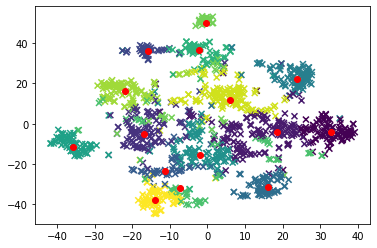

In [23]:
plot(model_stopwords, X, n_components=n_components)

The clusters look now not as good as before in my opinion. Maybe we need new k and n_components?

c:\users\jessi\documents\studium\ws20_21\text analytics\ita_ws20\.venv\lib\site-packages\ipykernel\ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


n_components:  2


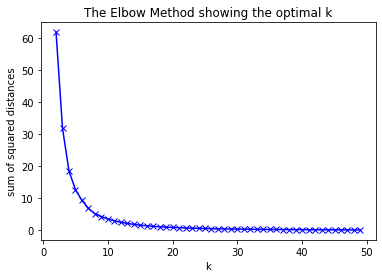

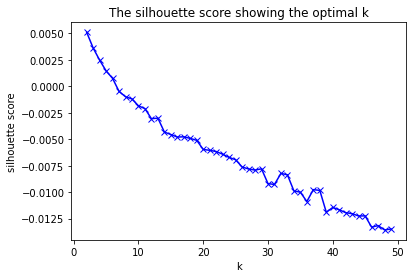

n_components:  3


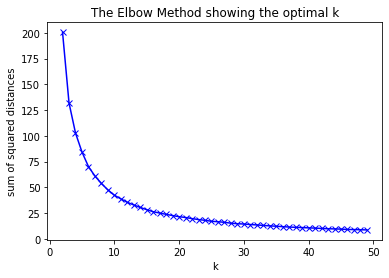

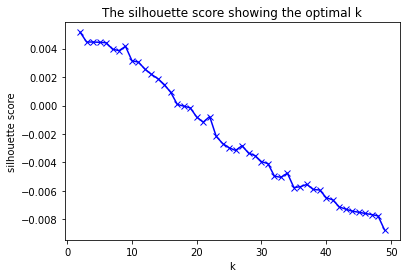

n_components:  4


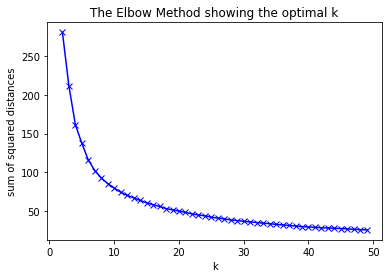

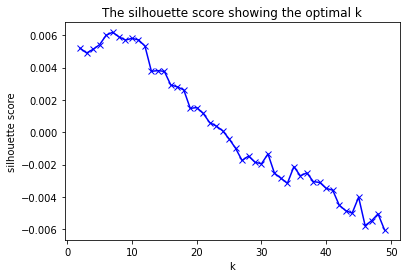

n_components:  5


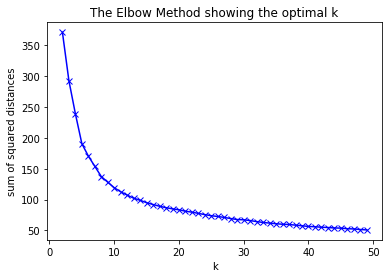

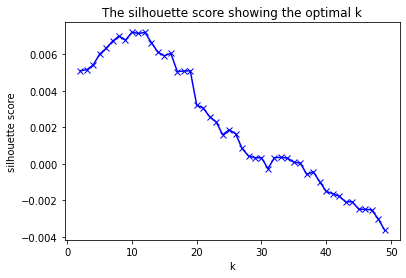

n_components:  6


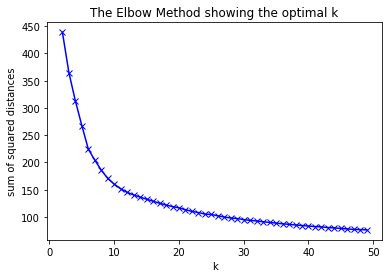

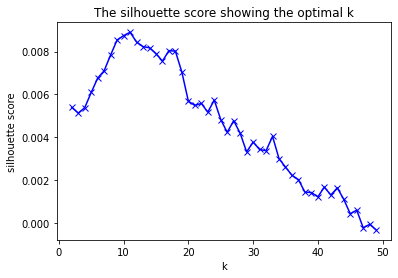

n_components:  7


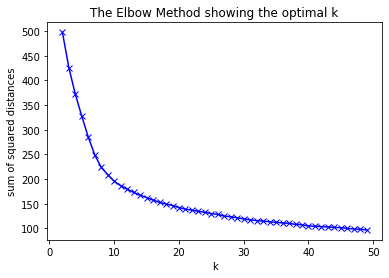

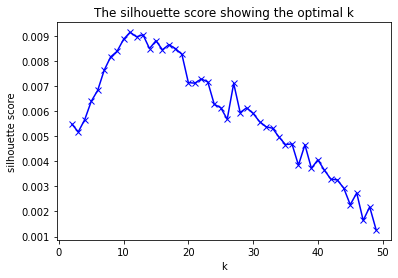

n_components:  8


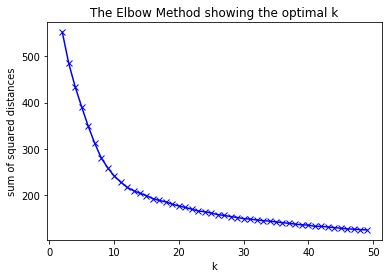

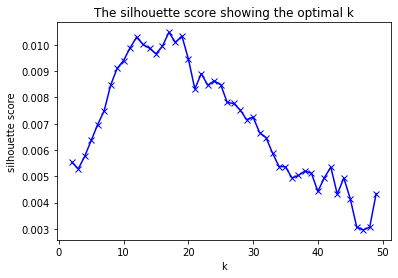

n_components:  9


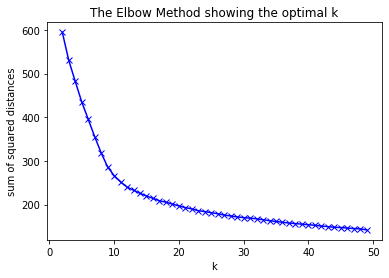

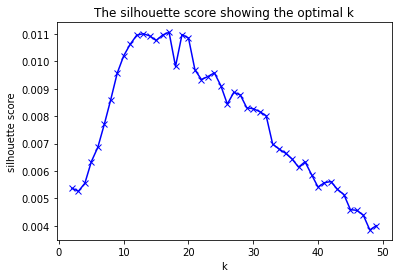

n_components:  10


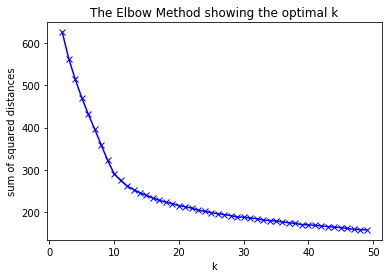

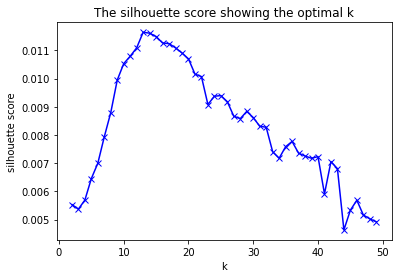

In [39]:
find_n_components_and_k(tfidf_corpus_stopwords)

Looks similar to before.

# Spectral Embedding
TODO: find optimal n_components

In [34]:
vectorizer_spec_embedding = TfidfVectorizer(tokenizer=lambda text: text, lowercase=False)  
tfidf_corpus_spec_embedding = vectorizer_spec_embedding.fit_transform(corpus["token"])
spectral_embedding = SpectralEmbedding(n_components=2)
tfidf_corpus_spec_embedding_array = spectral_embedding.fit_transform(tfidf_corpus_spec_embedding.toarray())

In [35]:
model_spectral = KMeans(n_clusters=num_topics, init='k-means++', max_iter=100, n_init=1)
model_spectral.fit(tfidf_corpus_spec_embedding_array)

KMeans(max_iter=100, n_clusters=15, n_init=1)

Getting the top terms of a cluster with the centroids is only possible, when getting the inverse spectral embedding of the centroids. Since this seems not to be possible, the top terms get extracted here the same way as in the other clustering algorithms, by getting the top words of each cluster.

In [42]:
def get_top_words(vectorizer, corpus):
    scores = zip(vectorizer.get_feature_names(),
                 np.asarray(corpus.sum(axis=0)).ravel())
    sorted_scores = list(zip(*sorted(scores, key=lambda x: x[1], reverse=True)))
    top_words = sorted_scores[0][:10]
    return top_words

def print_and_get_clusters_manually(model, vectorizer, corpus, n_components=None, svd=None):
    print("Top terms per cluster:")
    clusters = []
    for i in range(np.max(model.labels_)+1):
        print("Cluster %d:" % i),
        vectorizer, tfidf_corpus = get_tfidf_corpus(corpus.iloc[np.where(model.labels_ == i)])
        top_words = get_top_words(vectorizer, tfidf_corpus)
        print(top_words)
        clusters.append(get_top_words(vectorizer, tfidf_corpus))
        print("\n")
    return clusters

In [43]:
clusters_spectral = print_and_get_clusters_manually(model_spectral, vectorizer_spec_embedding, corpus)

Top terms per cluster:
Cluster 0:
('feature', 'learning', 'model', 'data', 'method', 'algorithm', 'problem', 'set', 'classifier', 'task')


Cluster 1:
('model', 'graph', 'algorithm', 'data', 'gaussian', 'variable', 'method', 'inference', 'process', 'network')


Cluster 2:
('regression', 'kernel', 'bound', 'method', 'algorithm', 'rate', 'learning', 'problem', 'function', 'estimator')


Cluster 3:
('learning', 'machine', 'algorithm', 'multi', 'package', 'framework', 'toolbox', 'library', 'weka', 'data')


Cluster 4:
('algorithm', 'learning', 'policy', 'problem', 'function', 'optimization', 'method', 'loss', 'distributed', 'online')


Cluster 5:
('kernel', 'learning', 'algorithm', 'data', 'method', 'problem', 'regression', 'function', 'bound', 'model')


Cluster 6:
('model', 'data', 'algorithm', 'method', 'clustering', 'approach', 'problem', 'regression', 'based', 'cluster')


Cluster 7:
('model', 'network', 'data', 'learning', 'neural', 'inference', 'graph', 'time', 'algorithm', 'set')



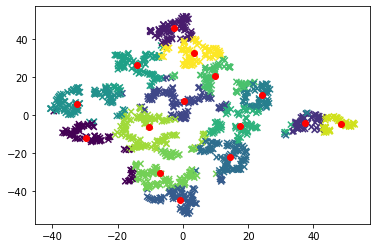

In [30]:
plot(model_spectral, tfidf_corpus_spec_embedding_array, n_components=2)

With Spectral Embedding and kmeans it looks nice clustered.

In [44]:
terms = list(itertools.chain.from_iterable(clusters_spectral))
Counter(terms).most_common

<bound method Counter.most_common of Counter({'algorithm': 14, 'data': 11, 'learning': 10, 'method': 10, 'model': 9, 'problem': 8, 'network': 4, 'kernel': 4, 'function': 4, 'set': 3, 'graph': 3, 'regression': 3, 'package': 3, 'task': 2, 'variable': 2, 'inference': 2, 'bound': 2, 'estimator': 2, 'machine': 2, 'multi': 2, 'toolbox': 2, 'library': 2, 'policy': 2, 'optimization': 2, 'loss': 2, 'clustering': 2, 'python': 2, 'feature': 1, 'classifier': 1, 'gaussian': 1, 'process': 1, 'rate': 1, 'framework': 1, 'weka': 1, 'distributed': 1, 'online': 1, 'approach': 1, 'based': 1, 'cluster': 1, 'neural': 1, 'time': 1, 'stochastic': 1, 'convex': 1, 'gradient': 1, 'convergence': 1, 'distribution': 1, 'dimensional': 1, 'source': 1, 'scikit': 1, 'label': 1, 'active': 1, 'classification': 1, 'image': 1, 'graphical': 1, 'causal': 1, 'latent': 1, 'effect': 1, 'matrix': 1, 'rank': 1, 'low': 1, 'sparse': 1, 'estimation': 1, 'covariance': 1})>

# Metrics

In [31]:
def calc_scores_arr(corpus, model):
    return metrics.silhouette_score(corpus, model.labels_, metric='euclidean'), metrics.calinski_harabasz_score(corpus, model.labels_), metrics.davies_bouldin_score(corpus, model.labels_)

def calc_scores(corpus, model):
    return calc_scores_arr(corpus.toarray(), model)

scores = []
score = list(calc_scores(tfidf_corpus, model))
score.insert(0, 'normal model')
scores.append(score)

score = list(calc_scores(tfidf_corpus_sklearn_preprocessed, model_skelarn_preprocessed))
score.insert(0, 'model_skelarn_preprocessed')
scores.append(score)

score = list(calc_scores(tfidf_corpus, model_lsa))
score.insert(0, 'model_lsa')
scores.append(score)

score = list(calc_scores(tfidf_corpus_stopwords, model_stopwords))
score.insert(0, 'model_stopwords')
scores.append(score)

score = list(calc_scores_arr(tfidf_corpus_spec_embedding_array, model_spectral))
score.insert(0, 'model with spectral embedding')
scores.append(score)

scores = pd.DataFrame(scores, columns=["model type","silhouette_score", "calinski_harabasz_score", "davies_bouldin_score"])
print(scores)

                      model type  silhouette_score  calinski_harabasz_score  \
0                   normal model          0.008014                 3.950907   
1     model_skelarn_preprocessed          0.006061                 3.468966   
2                      model_lsa          0.010770                 4.440964   
3                model_stopwords          0.011527                 4.623910   
4  model with spectral embedding          0.333162              1210.829372   

   davies_bouldin_score  
0              7.962139  
1              8.206699  
2              7.803102  
3              7.628154  
4              0.872538  
